In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import PIL
import cv2
import itertools
import numpy as np
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

2023-11-15 10:14:20.588995: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 10:14:20.601169: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 10:14:20.720306: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 10:14:20.721339: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 10:14:21.427605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
import pathlib
data_dir = pathlib.Path('/home/hduser/Desktop/augmented data/')
print(data_dir)

/home/hduser/Desktop/augmented data


/home/hduser/Desktop/augmented data/barbutellus/augmented_barbutellus_0_7377.jpg


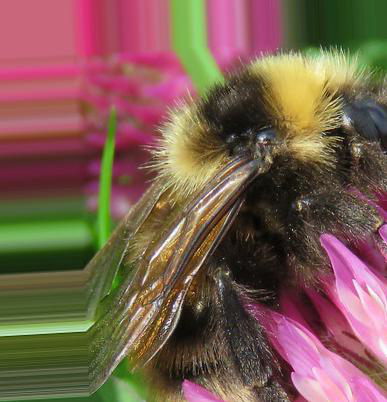

In [3]:
barbutellus = list(data_dir.glob('barbutellus/*'))
print(barbutellus[10])
PIL.Image.open(str(barbutellus[10]))

In [4]:
img_height, img_width = (224, 224)
batch_size = 32

In [5]:
train_batches = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2,
    subset='training', seed=8,
    #labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width), 
    batch_size=batch_size)

Found 6843 files belonging to 21 classes.
Using 5475 files for training.


2023-11-15 10:14:22.782041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: alecfei-linuxlaptop
2023-11-15 10:14:22.782059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: alecfei-linuxlaptop
2023-11-15 10:14:22.782177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-11-15 10:14:22.782201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  545.23.06  Release Build  (dvs-builder@U16-I3-C17-2-2)  Sun Oct 15 17:35:00 UTC 2023
GCC version:  gcc version 11.4.0 (Ubuntu 11.4.0-1ubuntu1~22.04) 
"


In [6]:
file_count = 0

for root, dirs, files in os.walk(data_dir):
    file_count += len(files)

print("Total number of files in the directory and its subdirectories:", file_count)

Total number of files in the directory and its subdirectories: 6843


In [7]:
validate_batches = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2,
    subset='validation', seed=8,
    label_mode='categorical',
    image_size=(img_height, img_width), 
    batch_size=batch_size)

Found 6843 files belonging to 21 classes.
Using 1368 files for validation.


In [8]:
class_names = train_batches.class_names
print(class_names)

['barbutellus', 'bohemicus', 'campestris', 'cryptarum', 'distinguendus', 'hortorum', 'hypnorum', 'jonellus', 'lapidarius', 'lucorum', 'magnus', 'monticola', 'muscorum', 'pascuorum', 'pratorum', 'ruderarius', 'rupestris', 'sylvarum', 'sylvestris', 'terrestris', 'vestalis']


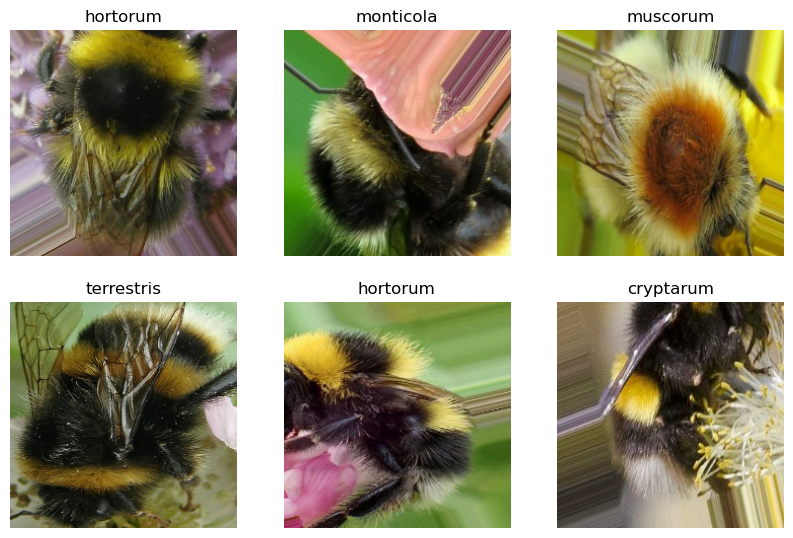

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_batches.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = labels[i].numpy().argmax()
        plt.title(class_names[label_index])
        plt.axis("off")

In [10]:
test_dir = pathlib.Path('/home/hduser/Desktop/testing dataset/')
print(test_dir)

/home/hduser/Desktop/testing dataset


## 1. ResNet50

In [11]:
resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in resnet50.layers:
        layer.trainable=False

In [12]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [13]:
model_resnet50 = Sequential()

model_resnet50.add(resnet50)
model_resnet50.add(Flatten())
model_resnet50.add(Dense(512, activation='relu'))
model_resnet50.add(Dropout(0.5))
#model_resnet50.add(Dense(256, activation='relu'))
#model_resnet50.add(Dropout(0.5))
#model_resnet50.add(Dense(128, activation='relu'))
#model_resnet50.add(Dropout(0.5))
#model_resnet50.add(Dense(64, activation='relu'))
#model_resnet50.add(Dense(32, activation='relu'))
model_resnet50.add(Dense(21, activation='softmax'))

In [14]:
model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 21)                10773     
                                                                 
Total params: 24647573 (94.02 MB)
Trainable params: 1059861 (4.04 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [15]:
model_resnet50.compile(optimizer=Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [16]:
epoch_resnet50 = 10

result_resnet50 = model_resnet50.fit(train_batches,
                                     validation_data=validate_batches,
                                     epochs=epoch_resnet50,
                                     verbose=2)

Epoch 1/10
172/172 - 116s - loss: 2.7648 - accuracy: 0.1837 - val_loss: 2.1098 - val_accuracy: 0.3743 - 116s/epoch - 677ms/step
Epoch 2/10
172/172 - 113s - loss: 2.0486 - accuracy: 0.3525 - val_loss: 1.6677 - val_accuracy: 0.5219 - 113s/epoch - 659ms/step
Epoch 3/10
172/172 - 112s - loss: 1.7246 - accuracy: 0.4532 - val_loss: 1.4542 - val_accuracy: 0.5541 - 112s/epoch - 654ms/step
Epoch 4/10
172/172 - 112s - loss: 1.5099 - accuracy: 0.5156 - val_loss: 1.3071 - val_accuracy: 0.6045 - 112s/epoch - 650ms/step
Epoch 5/10
172/172 - 112s - loss: 1.3511 - accuracy: 0.5620 - val_loss: 1.1449 - val_accuracy: 0.6630 - 112s/epoch - 651ms/step
Epoch 6/10
172/172 - 112s - loss: 1.2362 - accuracy: 0.5934 - val_loss: 1.0023 - val_accuracy: 0.6966 - 112s/epoch - 653ms/step
Epoch 7/10
172/172 - 113s - loss: 1.1318 - accuracy: 0.6281 - val_loss: 0.9446 - val_accuracy: 0.7346 - 113s/epoch - 659ms/step
Epoch 8/10
172/172 - 114s - loss: 1.0340 - accuracy: 0.6504 - val_loss: 0.9402 - val_accuracy: 0.7208 - 

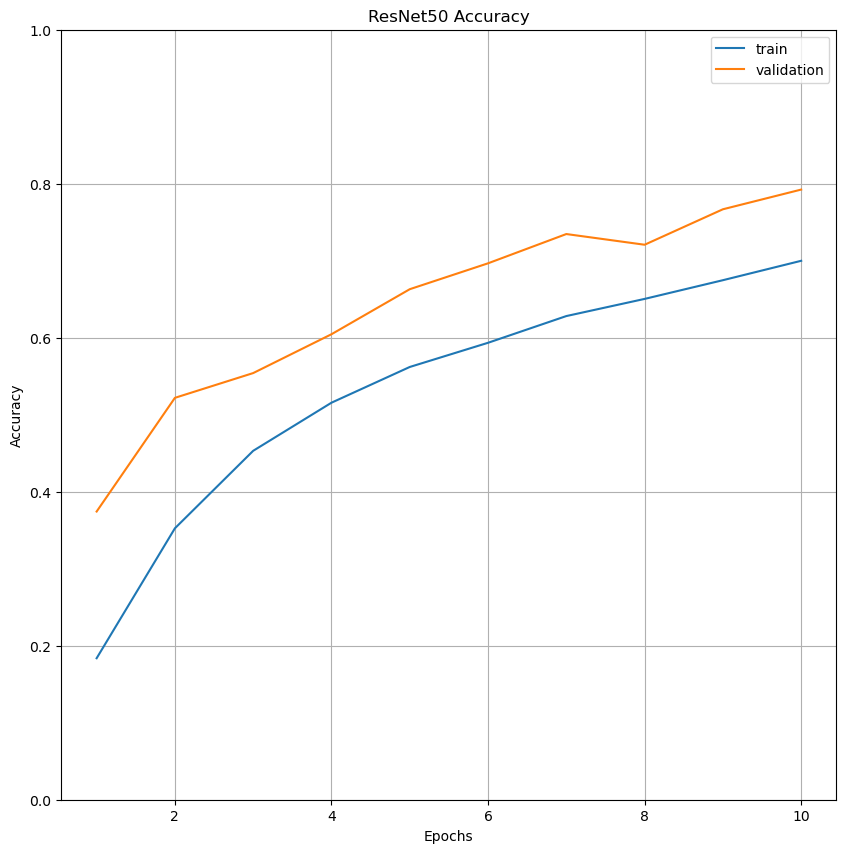

In [17]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_resnet50 + 1)
plt.plot(epochs_range, result_resnet50.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_resnet50.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('ResNet50 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

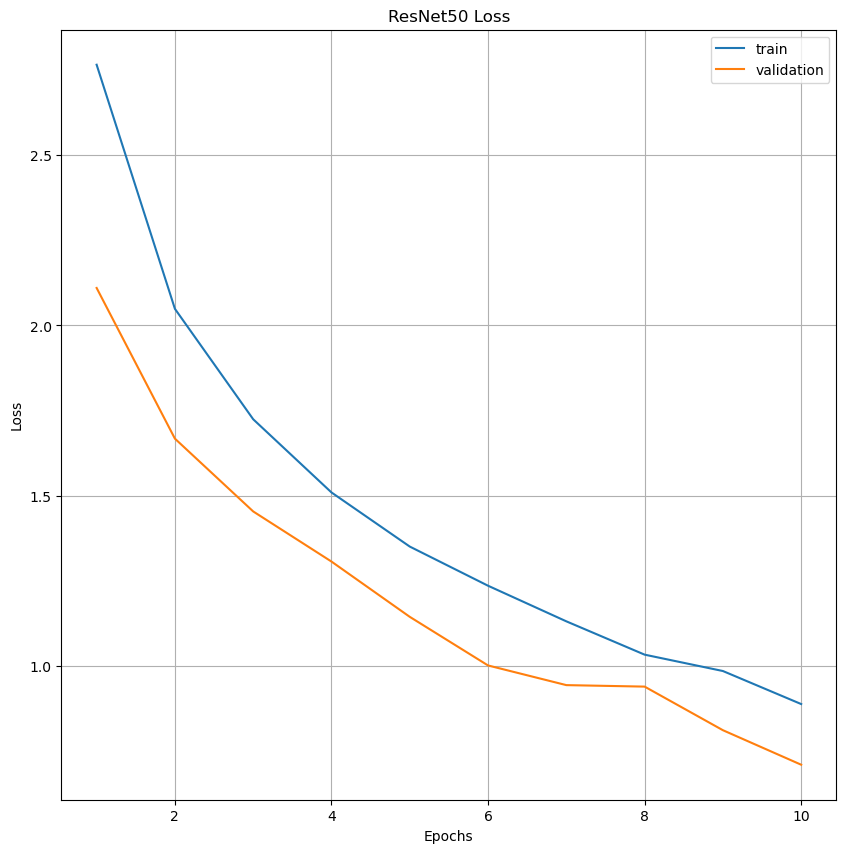

In [18]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_resnet50 + 1)
plt.plot(epochs_range, result_resnet50.history['loss'], label="Training Loss")
plt.plot(epochs_range, result_resnet50.history['val_loss'], label="Validation Loss")
plt.axis()
plt.grid()
plt.title('ResNet50 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

<br></br>
<font size="6">**Testing**</font>
<br></br>

In [19]:
barbutellus_test = list(test_dir.glob('bombus barbutellus/*'))
len(barbutellus_test)

18

/home/hduser/Desktop/testing dataset/bombus barbutellus/bombus barbutellus male 15.jpg


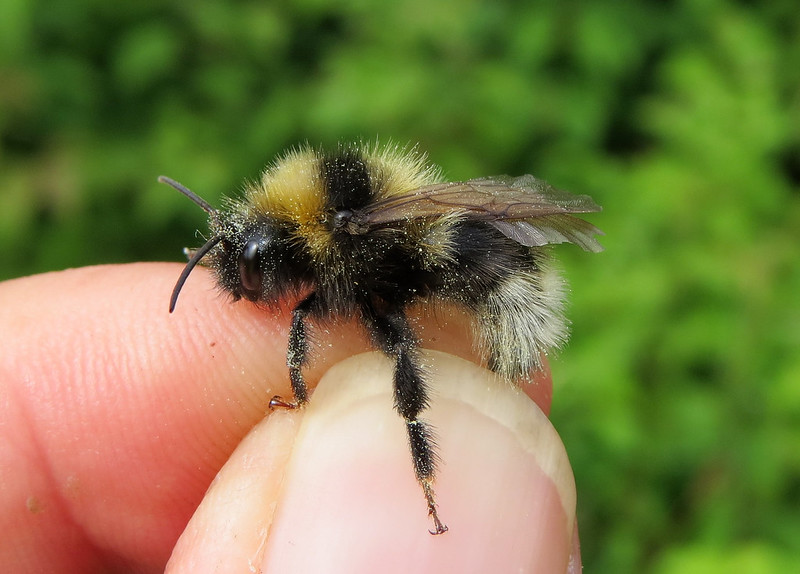

In [20]:
print(barbutellus_test[8])
PIL.Image.open(str(barbutellus_test[8]))

In [21]:
test_image=cv2.imread(str(barbutellus_test[8]))
test_image_resized=cv2.resize(test_image, (img_height, img_width))
test_image=np.expand_dims(test_image_resized, axis=0)

image_pil = PIL.Image.fromarray(test_image[0])
image_pil.show()

In [22]:
test_image_pred=model_resnet50.predict(test_image)

1/1 [==============================] - 1s 531ms/step


In [23]:
test_image_class=class_names[np.argmax(test_image_pred)]

print("The predicted class is: ", test_image_class)

The predicted class is:  bohemicus


In [24]:
terrestris_test = list(test_dir.glob('bombus terrestris/*'))
len(terrestris_test)

166

/home/hduser/Desktop/testing dataset/bombus terrestris/bombus terrestris queen 15 (melanic).jpg


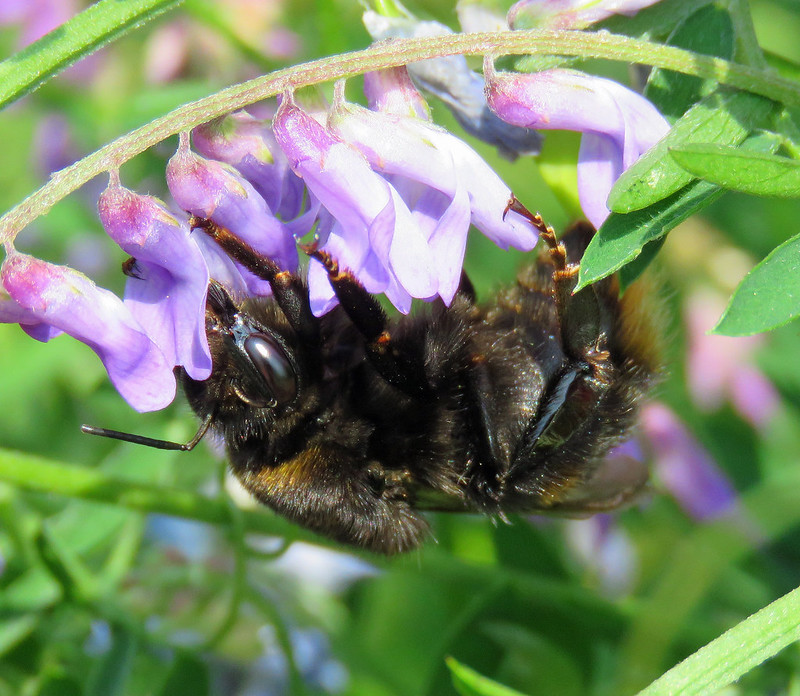

In [25]:
print(terrestris_test[9])
PIL.Image.open(str(terrestris_test[9]))

In [26]:
test_image=cv2.imread(str(terrestris_test[9]))
test_image_resized=cv2.resize(test_image, (img_height, img_width))
test_image=np.expand_dims(test_image_resized, axis=0)

image_pil = PIL.Image.fromarray(test_image[0])
image_pil.show()

In [27]:
test_image_pred=model_resnet50.predict(test_image)

1/1 [==============================] - 0s 44ms/step


In [28]:
test_image_class=class_names[np.argmax(test_image_pred)]

print("The predicted class is: ", test_image_class)

The predicted class is:  bohemicus


## 2. VGG19

In [29]:
vgg19 = tf.keras.applications.VGG19(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in vgg19.layers:
        layer.trainable=False

In [30]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [31]:
model_vgg19 = Sequential()

model_vgg19.add(vgg19)
model_vgg19.add(Flatten())
model_vgg19.add(Dense(512, activation='relu'))
model_vgg19.add(Dropout(0.5))
#model_vgg19.add(Dense(256, activation='relu'))
#model_vgg19.add(Dropout(0.5))
#model_vgg19.add(Dense(128, activation='relu'))
#model_vgg19.add(Dropout(0.5))
#model_vgg19.add(Dense(64, activation='relu'))
#model_vgg19.add(Dense(32, activation='relu'))
model_vgg19.add(Dense(21, activation='softmax'))

In [32]:
model_vgg19.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 21)                10773     
                                                                 
Total params: 20297813 (77.43 MB)
Trainable params: 273429 (1.04 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [33]:
model_vgg19.compile(optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [34]:
epoch_vgg19 = 10

result_vgg19 = model_vgg19.fit(train_batches,
                               validation_data=validate_batches,
                               epochs=epoch_vgg19,
                               verbose=2)

Epoch 1/10
172/172 - 380s - loss: 3.8041 - accuracy: 0.1226 - val_loss: 2.5201 - val_accuracy: 0.2661 - 380s/epoch - 2s/step
Epoch 2/10
172/172 - 382s - loss: 2.4414 - accuracy: 0.2588 - val_loss: 2.0382 - val_accuracy: 0.3969 - 382s/epoch - 2s/step
Epoch 3/10
172/172 - 380s - loss: 2.0698 - accuracy: 0.3529 - val_loss: 1.7638 - val_accuracy: 0.4613 - 380s/epoch - 2s/step
Epoch 4/10
172/172 - 380s - loss: 1.8380 - accuracy: 0.4153 - val_loss: 1.6070 - val_accuracy: 0.5000 - 380s/epoch - 2s/step
Epoch 5/10
172/172 - 381s - loss: 1.6544 - accuracy: 0.4740 - val_loss: 1.4856 - val_accuracy: 0.5300 - 381s/epoch - 2s/step
Epoch 6/10
172/172 - 381s - loss: 1.5204 - accuracy: 0.5074 - val_loss: 1.3352 - val_accuracy: 0.5841 - 381s/epoch - 2s/step
Epoch 7/10
172/172 - 380s - loss: 1.3776 - accuracy: 0.5549 - val_loss: 1.2940 - val_accuracy: 0.5855 - 380s/epoch - 2s/step
Epoch 8/10
172/172 - 379s - loss: 1.2629 - accuracy: 0.5931 - val_loss: 1.1518 - val_accuracy: 0.6389 - 379s/epoch - 2s/step


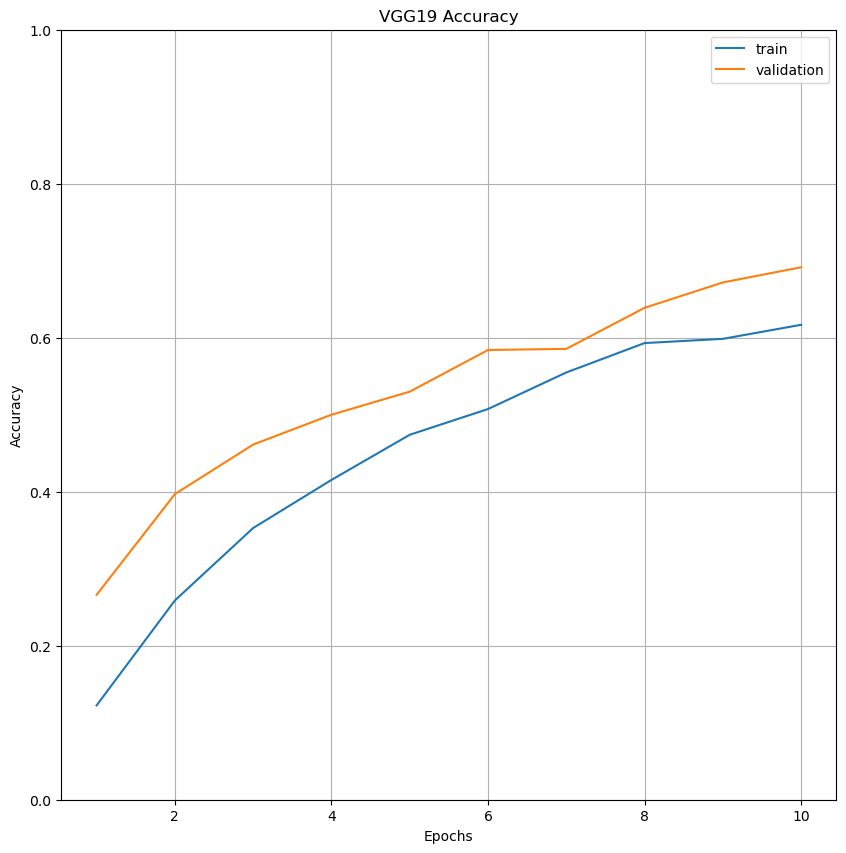

In [35]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_vgg19 + 1)
plt.plot(epochs_range, result_vgg19.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_vgg19.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('VGG19 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

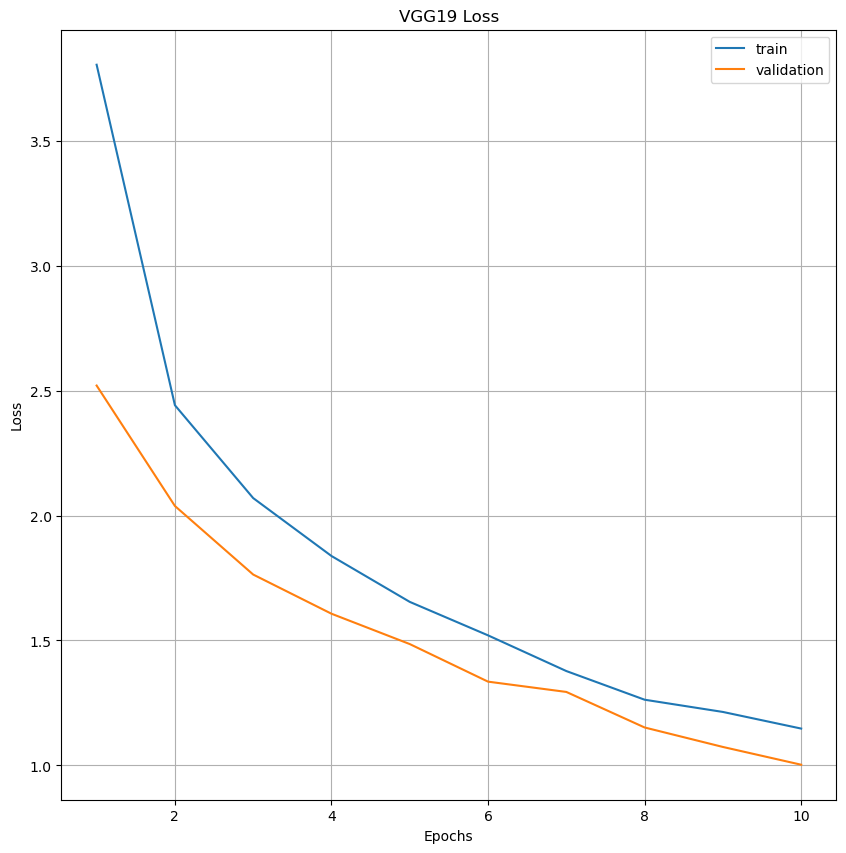

In [36]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_vgg19 + 1)
plt.plot(epochs_range, result_vgg19.history['loss'], label="Training Loss")
plt.plot(epochs_range, result_vgg19.history['val_loss'], label="Validation Loss")
plt.axis()
plt.grid()
plt.title('VGG19 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

<br></br>
<font size="6">**Testing**</font>
<br></br>

In [37]:
bohemicus_test = list(test_dir.glob('bombus bohemicus/*'))
len(bohemicus_test)

2

/home/hduser/Desktop/testing dataset/bombus bohemicus/bombus bohemicus male 9.jpg


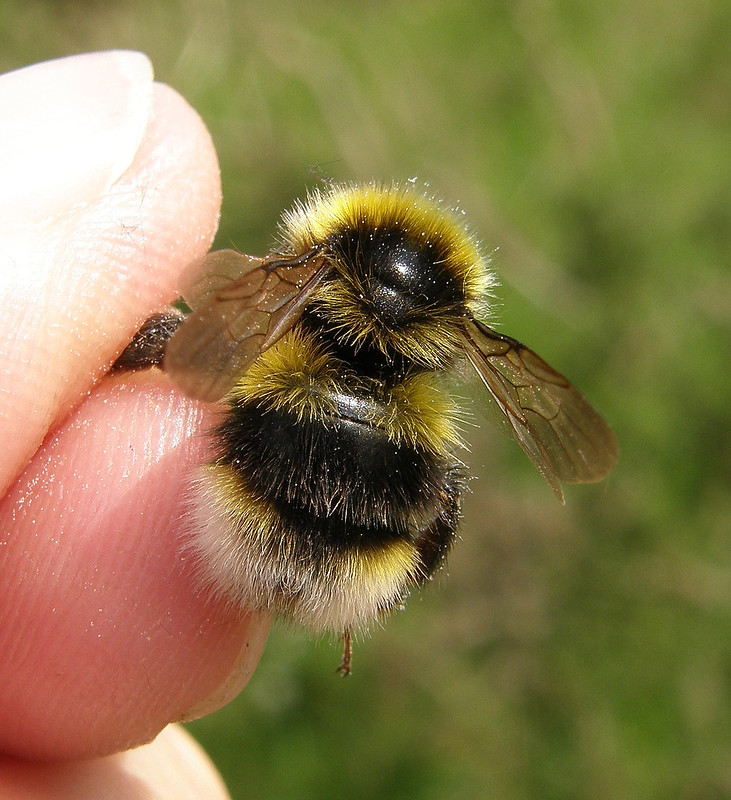

In [38]:
print(bohemicus_test[1])
PIL.Image.open(str(bohemicus_test[1]))

In [39]:
test_image=cv2.imread(str(bohemicus_test[1]))
test_image_resized=cv2.resize(test_image, (img_height, img_width))
test_image=np.expand_dims(test_image_resized, axis=0)

image_pil = PIL.Image.fromarray(test_image[0])
image_pil.show()

In [40]:
test_image_pred=model_vgg19.predict(test_image)

1/1 [==============================] - 0s 154ms/step


In [41]:
test_image_class=class_names[np.argmax(test_image_pred)]

print("The predicted class is: ", test_image_class)

The predicted class is:  jonellus


## 3. InceptionV3

In [42]:
inceptionv3 = tf.keras.applications.InceptionV3(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in inceptionv3.layers:
        layer.trainable=False

In [43]:
inceptionv3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

 conv2d_11 (Conv2D)          (None, 25, 25, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 25, 25, 64)           192       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 25, 25, 64)           192       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 25, 25, 96)           288       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 25, 25, 64)           0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 25, 25, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_28 (Conv2D)          (None, 25, 25, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 25, 25, 96)           288       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 12, 12, 384)          995328    ['mixed2[0][0]']              
          

 conv2d_30 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_33 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_38 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_39 (Conv2D)          (None, 12, 12, 192)          147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, 12, 12, 192)          576       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 12, 12, 768)          0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_40 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_43 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_48 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 12, 12, 768)          0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_50

 batch_normalization_62 (Ba  (None, 12, 12, 192)          576       ['conv2d_62[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, 12, 12, 192)          576       ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_71 (Conv2D)          (None, 5, 5, 320)            552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_75 (Conv2D)          (None, 5, 5, 192)            331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 5, 5, 320)            960       ['conv2d_71[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, 5, 5, 192)            576       ['conv2d_75[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, 5, 5, 192)            576       ['conv2d_84[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

In [44]:
model_inceptionv3 = Sequential()

model_inceptionv3.add(inceptionv3)
model_inceptionv3.add(Flatten())
model_inceptionv3.add(Dense(512, activation='relu'))
model_inceptionv3.add(Dropout(0.5))
#model_inceptionv3.add(Dense(256, activation='relu'))
#model_inceptionv3.add(Dropout(0.5))
#model_inceptionv3.add(Dense(128, activation='relu'))
#model_inceptionv3.add(Dropout(0.5))
#model_resnet50.add(Dense(64, activation='relu'))
#model_resnet50.add(Dense(32, activation='relu'))
model_inceptionv3.add(Dense(21, activation='softmax'))

In [45]:
model_inceptionv3.summary()    

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 21)                10773     
                                                                 
Total params: 22862645 (87.21 MB)
Trainable params: 1059861 (4.04 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [46]:
model_inceptionv3.compile(optimizer=Adam(learning_rate=0.01),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

In [ ]:
epoch_inceptionv3 = 10

result_inceptionv3 = model_inceptionv3.fit(train_batches,
                                           validation_data=validate_batches,
                                           epochs=epoch_inceptionv3,
                                           verbose=2)

Epoch 1/10
172/172 - 60s - loss: 28.5945 - accuracy: 0.0405 - val_loss: 3.0476 - val_accuracy: 0.0402 - 60s/epoch - 350ms/step
Epoch 2/10
172/172 - 58s - loss: 3.1740 - accuracy: 0.0393 - val_loss: 3.0484 - val_accuracy: 0.0402 - 58s/epoch - 337ms/step
Epoch 3/10


In [ ]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_inceptionv3 + 1)
plt.plot(epochs_range, result_inceptionv3.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_inceptionv3.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('InceptionV3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_inceptionv3 + 1)
plt.plot(epochs_range, result_inceptionv3.history['loss'], label="Training Loss")
plt.plot(epochs_range, result_inceptionv3.history['val_loss'], label="Validation Loss")
plt.axis()
plt.grid()
plt.title('InceptionV3 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## 4. MobileNetV2

In [ ]:
mobilenetv2 = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in mobilenetv2.layers:
        layer.trainable=False

In [ ]:
mobilenetv2.summary()

In [ ]:
model_mobilenetv2 = Sequential()

model_mobilenetv2.add(mobilenetv2)
model_mobilenetv2.add(Flatten())
model_mobilenetv2.add(Dense(512, activation='relu'))
model_mobilenetv2.add(Dropout(0.5))
#model_mobilenetv2.add(Dense(256, activation='relu'))
#model_mobilenetv2.add(Dropout(0.5))
#model_mobilenetv2.add(Dense(128, activation='relu'))
#model_mobilenetv2.add(Dropout(0.5))
#model_mobilenetv2.add(Dense(64, activation='relu'))
#model_mobilenetv2.add(Dense(32, activation='relu'))
model_mobilenetv2.add(Dense(21, activation='softmax'))

In [ ]:
model_mobilenetv2.summary()

In [ ]:
model_mobilenetv2.compile(optimizer=Adam(learning_rate=0.001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

In [ ]:
epoch_mobilenetv2 = 10

result_mobilenetv2 = model_mobilenetv2.fit(train_batches,
                                           validation_data=validate_batches,
                                           epochs=epoch_mobilenetv2,
                                           verbose=2)

In [ ]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_mobilenetv2 + 1)
plt.plot(epochs_range, result_mobilenetv2.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_mobilenetv2.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('MoblieNetV2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_mobilenetv2 + 1)
plt.plot(epochs_range, result_mobilenetv2.history['loss'], label="Training Loss")
plt.plot(epochs_range, result_mobilenetv2.history['val_loss'], label="Validation Loss")
plt.axis()
plt.grid()
plt.title('MobileNetV2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## 5. VGG16

In [ ]:
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in vgg16.layers:
        layer.trainable=False

In [ ]:
vgg16.summary()

In [ ]:
model_vgg16 = Sequential()

model_vgg16.add(vgg16)
model_vgg16.add(Flatten())
model_vgg16.add(Dense(512, activation='relu'))
model_vgg16.add(Dropout(0.5))
#model_vgg16.add(Dense(256, activation='relu'))
#model_vgg16.add(Dropout(0.5))
#model_vgg16.add(Dense(128, activation='relu'))
#model_vgg16.add(Dropout(0.5))
#model_vgg16.add(Dense(64, activation='relu'))
#model_vgg16.add(Dense(32, activation='relu'))
model_vgg16.add(Dense(21, activation='softmax'))

In [ ]:
model_vgg16.summary()

In [ ]:
model_vgg16.compile(optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
epoch_vgg16 = 10

result_vgg16 = model_vgg16.fit(train_batches,
                               validation_data=validate_batches,
                               epochs=epoch_vgg16,
                               verbose=2)

In [ ]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_vgg16 + 1)
plt.plot(epochs_range, result_vgg16.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_vgg16.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('VGG16 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_vgg16 + 1)
plt.plot(epochs_range, result_vgg16.history['loss'], label="Training Loss")
plt.plot(epochs_range, result_vgg16.history['val_loss'], label="Validation Loss")
plt.axis()
plt.grid()
plt.title('VGG16 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## 6. InceptionResnetV2

In [ ]:
inceptionresnetv2 = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in inceptionresnetv2.layers:
        layer.trainable=False

In [ ]:
inceptionresnetv2.summary()

In [ ]:
model_inceptionresnetv2 = Sequential()

model_inceptionresnetv2.add(inceptionresnetv2)
model_inceptionresnetv2.add(Flatten())
model_inceptionresnetv2.add(Dense(512, activation='relu'))
model_inceptionresnetv2.add(Dropout(0.5))
#model_inceptionresnetv2.add(Dense(256, activation='relu'))
#model_inceptionresnetv2.add(Dropout(0.5))
#model_inceptionresnetv2.add(Dense(128, activation='relu'))
#model_inceptionresnetv2.add(Dropout(0.5))
#model_inceptionresnetv2.add(Dense(64, activation='relu'))
#model_inceptionresnetv2.add(Dense(32, activation='relu'))
model_inceptionresnetv2.add(Dense(21, activation='softmax'))

In [ ]:
model_inceptionresnetv2.summary()

In [ ]:
model_inceptionresnetv2.compile(optimizer=Adam(learning_rate=0.001),
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

In [ ]:
epoch_inceptionresnetv2 = 10

result_inceptionresnetv2 = model_inceptionresnetv2.fit(train_batches,
                                    validation_data=validate_batches,
                                      epochs=epoch_inceptionresnetv2,
                                                           verbose=2)

In [ ]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_inceptionresnetv2 + 1)
plt.plot(epochs_range, result_inceptionresnetv2.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_inceptionresnetv2.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('InceptionResnetV2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_inceptionresnetv2 + 1)
plt.plot(epochs_range, result_inceptionresnetv2.history['loss'], label="Training Loss")
plt.plot(epochs_range, result_inceptionresnetv2.history['val_loss'], label="Validation Loss")
plt.axis()
plt.grid()
plt.title('InceptionResnetV2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## Local Interpretable Model-agnostic Explanations (LIME)

In [ ]:
#!pip3 install lime

In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from keras.preprocessing import image
from tensorflow.keras.applications import resnet50
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread

In [ ]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(img_height, img_width))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = resnet50.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

In [ ]:
images = transform_img_fn([os.path.join('/home/hduser/Desktop/testing dataset/bombus hypnorum','bombus hypnorum queen 2.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)

preds = model_resnet50.predict(images)
# Assuming preds is a 2D array with shape (1, 21)
top_classes = np.argsort(preds[0])[-21:][::-1]  # Get indices of the top 21 predictions

for class_index in top_classes:
    class_label = class_names[class_index]
    confidence = preds[0, class_index]
    print(f"Class: {class_label}, Confidence: {confidence}")


In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
explanation = explainer.explain_instance(images[0].astype('double'), 
                                         model_resnet50.predict, 
                                         top_labels=5, hide_color=0, num_samples=1000)

<br> </br>
- top 5 superpixels that are most positive towards the class

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, 
                                            num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, 
                                            num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>
- pros and cons (pros in green, cons in red)

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, 
                                            num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>
- the pros and cons that have weight at least 0.1

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, num_features=1000, 
                                            hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<br> </br>
- heatmap visualization

In [ ]:
from functools import partial

#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])

# Set default value for None entries
default_value = 0  # You can adjust this value based on your preferences

# Create a custom function to handle default value
def get_with_default(key):
    return dict_heatmap.get(key, default_value)

# Vectorize the function using np.vectorize
vectorized_get_with_default = np.vectorize(get_with_default, otypes=[np.float64])
heatmap = vectorized_get_with_default(explanation.segments)

# Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap='RdBu', vmin=-np.max(np.abs(heatmap)), vmax=np.max(np.abs(heatmap)))
plt.colorbar()
plt.show()

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], 
                                            positive_only=True, 
                                            num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))